In [107]:
import matplotlib
#matplotlib.use('Agg')
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
#sns.set()

In [108]:
import numpy as np
import h5py
from getdist import plots, MCSamples
from glob import glob
from os import path
from copy import deepcopy
from collections import OrderedDict
from os.path import basename

In [109]:
boxno = 1

In [110]:
fnames = sorted(glob('/u/ki/swmclau2/des/PearceMCMC/HOD_%d_1_rmin_1.0_Knn1pCDF.hdf5'%boxno))
#fnames.extend(glob('/u/ki/swmclau2/des/PearceMCMC/HOD_%d_1_rmin_1.0_Knn4CDF.hdf5'%boxno))
#fnames.extend(glob('/u/ki/swmclau2/des/PearceMCMC/HOD_%d_1_rmin_1.0_Xi.hdf5'%boxno))
#fnames.extend(glob('/u/ki/swmclau2/des/PearceMCMC/HOD_%d_1_rmin_1.0_Xi+Knn1CDF.hdf5'%boxno))

Assume all chains run with same true values, only thing that differs is the rmin. 

In [111]:
model = path.basename(fnames[0]).split('_')[-1].split('.')[0]
#model = path.basename(fnames[0]).split('_')[-2]#.split('.')[0]

In [112]:
model

'Knn1pCDF'

In [113]:
f = h5py.File(fnames[0], 'r')

In [114]:
f.attrs.keys()

[u'chain_fixed_params',
 u'cov',
 u'dlogz',
 u'emu_cov_fname',
 u'emu_hps',
 u'emu_type',
 u'fixed_params',
 u'mcmc_type',
 u'nburn',
 u'nlive',
 u'nsteps',
 u'nwalkers',
 u'obs',
 u'param_names',
 u'seed',
 u'sim',
 u'training_file',
 u'true_cov_fname',
 u'true_data_fname']

In [115]:
f.keys()

[u'chain', u'cov', u'data', u'lnprob']

In [116]:
n_walkers = f.attrs['nwalkers']

In [117]:
chain_pnames = list(f.attrs['param_names'])

In [118]:
chain_pnames.extend(['Om', 'S8']) # temporary

In [119]:
sim_info = eval(f.attrs['sim'])
#sim_info = f.attrs['sim']

In [120]:
#gal_type = eval(f.attrs['sim'])['gal_type']
if basename(fnames[0])[:3] == 'HOD' and basename(fnames[0])[4:9] != 'MDPL2':
    gal_type = 'HOD'
else:
    gal_type = 'SHAM'#'HOD'

In [121]:
f.close()

In [122]:
chain_pnames

['ombh2',
 'omch2',
 'w0',
 'ns',
 'H0',
 'Neff',
 'sigma8',
 'mean_occupation_centrals_assembias_param1',
 'logM0',
 'sigma_logM',
 'mean_occupation_satellites_assembias_param1',
 'logM1',
 'alpha',
 'conc_gal_bias',
 'Om',
 'S8']

In [123]:
param_name_dict = {'ombh2': r'\Omega_b h^2', 'omch2': r'\Omega_c h^2','w0': r'w_0',\
                   'ns': r'n_s', \
                   'sigma8': r'\sigma_8', 'ln10As':r'\ln 10^{10} A_s', 'H0': r'H_0',\
                   'Neff': r'N_{eff}',\
               
                   'mean_occupation_centrals_assembias_param1': r'\mathcal{A}_{cen}',\
                 'mean_occupation_satellites_assembias_param1':r'\mathcal{A}_{sat}',\
                   
                   'logM1': r'\log(M_1)','logM0': r'\log(M_0)',
                   'sigma_logM': r'\sigma_{\log M }',
                   'conc_gal_bias': r'\eta', 'alpha':r'\alpha',
                  'Om': r'\Omega_m', 'S8': r'S_8'}

In [124]:
bounds_dict = {'H0': (61.69472, 74.76751999999999),
 'Neff': (2.62125, 4.27875),
 'alpha': (0.7, 1.3),
 'conc_gal_bias': (0.5, 2.0),
 'sigma8': (0.65, 1.0), # TODO update
 'logM0': (12.6, 13.6),
 'logM1': (13.7, 14.7),
 'ns': (0.9278462, 0.9974495999999999),
 'ombh2': (0.02066455, 0.02371239),
 'omch2': (0.1012181, 0.13177679999999997),
 'sigma_logM': (0.05, 0.6),
 'ln10As': (3.0, 3.1),
 'w0': (-1.399921, -0.5658486),
 'Om': (0.25, 0.35),
 'S8': (0.7, 1.0),
 #'Om': (0.15, 0.4),
 #'S8': (0.5, 1.1),
 'mean_occupation_centrals_assembias_corr1': (-1.0, 1.0),
 'mean_occupation_satellites_assembias_corr1': (-1.0, 1.0),
 'mean_occupation_centrals_assembias_param1': (-1.0, 1.0),
 'mean_occupation_satellites_assembias_param1': (-1.0, 1.0),
 'mean_occupation_centrals_assembias_slope1': (-3.0, 3.0),
 'mean_occupation_satellites_assembias_slope1': (-3.0, 3.0)}

In [125]:
hod_param_names = []
cosmo_param_names = []

hod_bounds = []
cosmo_bounds = []
cosmo_names = set(['ombh2', 'omch2', 'w0', 'ns', 'sigma8', 'H0', 'Neff', 'ln10As', 'Om', 'S8'])
for pname in chain_pnames:
    if pname in cosmo_names:
        cosmo_param_names.append(pname)#param_name_dict[pname])
        cosmo_bounds.append(bounds_dict[pname])
    else:
        hod_param_names.append(pname)#param_name_dict[pname])
        hod_bounds.append(bounds_dict[pname])
param_names = deepcopy(cosmo_param_names)
param_names.extend(hod_param_names)

bounds = deepcopy(cosmo_bounds)
bounds.extend(hod_bounds)

In [126]:
def modify_chain(chain, param_names):
    new_pnames = ['Om', 'S8']
    h = chain[:,param_names.index('H0')]/100
    
    Omc, Omb = chain[:,param_names.index('omch2')]/(h**2), chain[:,param_names.index('ombh2')]/(h**2)
    Om = Omc+Omb
    
    S8 = chain[:,param_names.index('sigma8')]*np.sqrt(Om/0.3)

    new_chain = np.hstack([chain[:,:7], Om.reshape((-1,1)), S8.reshape((-1,1)), chain[:,7:]])
    param_names.insert(7, new_pnames[0])
    param_names.insert(8, new_pnames[1])

    return new_chain, param_names

In [127]:
n_burn = 1000
global_chain_pnames = []
global_hod_pnames = []
all_samples = []
#for name, fname in zip(['wp','ds','wpds'], fnames):
for fname in fnames:
#for fname in [fnames[0], fnames[3]]:
    try:
        f = h5py.File(fname, 'r')

        chain = f['chain'][n_burn*n_walkers:]
        lnprob = f['lnprob'][n_burn*n_walkers:]
        keep_idxs = np.all(chain!=0.0, axis = 1)
        chain = chain[keep_idxs, :]
        lnprob = lnprob[keep_idxs]
    except:
        print 'Error loading', fname
        continue
    

    chain = chain.reshape((-1, n_walkers, chain.shape[1]))
    #print chain.shape
    chain = chain.reshape((-1, chain.shape[2]), order = 'F')
    lnprob = lnprob.reshape((-1, n_walkers)).reshape((-1,), order = 'F')
    
    if np.any(np.isnan(lnprob)) or np.any(~np.isfinite(lnprob)):
        lnprob[np.isnan(lnprob)] = -1e9
        lnprob[~np.isfinite(lnprob)] = -1e9
    #chain = chain[:, 0, :]
    if chain.shape[0] == 0:
        print 'Insufficient samples in', fname
        continue
    if path.basename(fname).split('_')[-1][:1] == 'v':
        name = path.basename(fname).split('_')[-2]#.split('.')[0]
    else:
        name = path.basename(fname).split('_')[-1].split('.')[0]

    #name = path.basename(fname).split('_')[-2]#[4][5]
    #name = path.basename(fname).split('_')[0]
    #name = path.basename(fname).split('_')[-4]#[4][5]

    if name == 'Xi':
        name = r'$\xi_{gg}$'
    elif name[:3] == 'Knn':
        if name[-3:]=='All':
            name = r'$k$NN-CDF, k=%s'%'[1,2,4,8]'
        else:
            name = r'$k$NN-CDF, k=%s'%name[3]
    elif name[:6] == 'Xi+Knn':
        name = r'$\xi_{gg}$ + $k$NN-CDF, k=%s'%name[6]

        
    #name = r"$r_{min} = %s$"%name
    
    hod_param_names = []
    cosmo_param_names = []
    chain_pnames = list(f.attrs['param_names'])
    cosmo_names = set(['ombh2', 'omch2', 'w0', 'ns', 'sigma8', 'H0', 'Neff', 'Om', 'S8'])
    
    chain, chain_pnames = modify_chain(chain, chain_pnames)
    max_steps = 100000
    if chain.shape[0]/n_walkers > max_steps:
        chain = chain[:max_steps*n_walkers]
        lnprob = lnprob[:max_steps*n_walkers]
    
    for pname in chain_pnames:
        if pname in cosmo_names:
            cosmo_param_names.append(param_name_dict[pname])
        else:
            hod_param_names.append(param_name_dict[pname])

    param_names = deepcopy(cosmo_param_names)
    param_names.extend(hod_param_names)
    print fname

    print chain.shape[0]/n_walkers
    
    #c.add_chain(chain, parameters=param_names, name = name, walkers = n_walkers,
    #            posterior = lnprob)
    print param_names
    samples = MCSamples(samples=chain,names = chain_pnames, labels = param_names,\
                        label =name,settings={'mult_bias_correction_order':0,\
                                              'smooth_scale_2D':0.1,\
                                              'smooth_scale_1D':0.1})
    
    all_samples.append(samples)

    f.close()

    for cname in chain_pnames:
        if cname not in global_chain_pnames:
            global_chain_pnames.append(cname)
            
    for cname in hod_param_names:
        if cname not in global_hod_pnames:
            global_hod_pnames.append(cname) 
            
chain_pnames = global_chain_pnames
hod_param_names = global_hod_pnames

/u/ki/swmclau2/des/PearceMCMC/HOD_1_1_rmin_1.0_Knn1pCDF.hdf5
12185
['\\Omega_b h^2', '\\Omega_c h^2', 'w_0', 'n_s', 'H_0', 'N_{eff}', '\\sigma_8', '\\Omega_m', 'S_8', '\\mathcal{A}_{cen}', '\\log(M_0)', '\\sigma_{\\log M }', '\\mathcal{A}_{sat}', '\\log(M_1)', '\\alpha', '\\eta']
Removed no burn in


In [128]:
param_names

['\\Omega_b h^2',
 '\\Omega_c h^2',
 'w_0',
 'n_s',
 'H_0',
 'N_{eff}',
 '\\sigma_8',
 '\\Omega_m',
 'S_8',
 '\\mathcal{A}_{cen}',
 '\\log(M_0)',
 '\\sigma_{\\log M }',
 '\\mathcal{A}_{sat}',
 '\\log(M_1)',
 '\\alpha',
 '\\eta']

In [129]:
f.close()

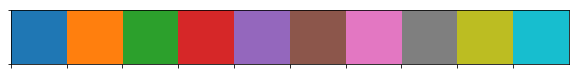

In [130]:
sns.palplot(sns.color_palette())

$k$NN-CDF, k=1


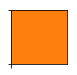

In [131]:
palette_idxs = []
for  _c in all_samples:
    #print _c.__dict__.keys()
    model = _c.label#[:-3]
    print model
    if model == r'$\xi_{gg}$':
        #palette = sns.cubehelix_palette(len(fnames), start = 2.6, rot = 0.1, gamma = 0.7)
        #palette = sns.cubehelix_palette(len(fnames), start = 2.6, rot = 0.1, gamma =1.5)
        idx = 0
    elif model == r'$k$NN-CDF, k=1' or model =='Knn1pCDF':
        #palette = sns.cubehelix_palette(len(fnames), start = 2.0, rot = 0.1, gamma = 1.5)
        #palette = sns.cubehelix_palette(len(fnames), start = 1.2, rot = 0.6, gamma = 1.7)
        idx = 1
    elif model ==  r'$k$NN-CDF, k=2'or model =='Knn2pCDF':
        #palette = sns.cubehelix_palette(len(fnames), start = 0.6, rot = 0.1, gamma = 1.5)
        idx =2 
    elif model ==  r'$k$NN-CDF, k=4'or model =='Knn4pCDF':
        #palette = sns.cubehelix_palette(len(fnames), start = 1.2, rot = 0.1, gamma = 1.2)
        #palette = sns.cubehelix_palette(len(fnames), start = 1.2, rot = 0.1, gamma = 1.0)
        idx = 3
    elif model ==  r'$k$NN-CDF, k=8'or model =='Knn8pCDF':
        #palette = sns.cubehelix_palette(len(fnames), start = 1.2, rot = 0.1, gamma = 1.2)
        #palette = sns.cubehelix_palette(len(fnames), start = 1.2, rot = 0.1, gamma = 1.0)
        idx = 4
    elif model == r'$k$NN-CDF, k=%s'%'[1,2,4,8]':
        #palette = sns.cubehelix_palette(len(fnames), start = 1.2, rot = 0.1, gamma = 1.2)
        #palette = sns.cubehelix_palette(len(fnames), start = 1.2, rot = 0.1, gamma = 1.0)
        idx = 5
    elif model == r'$\xi_{gg}$ + $k$NN-CDF, k=1':
        #palette = sns.cubehelix_palette(len(fnames), start = 1.2, rot = 0.1, gamma = 1.2)
        #palette = sns.cubehelix_palette(len(fnames), start = 1.2, rot = 0.1, gamma = 1.0)
        idx = 6
    else:
        #raise NotImplementedError
    #palettes.append(palette[0])
        idx = 0
    palette_idxs.append(idx)

palette = [sns.color_palette()[i] for i in palette_idxs]    
sns.palplot(palette)

In [132]:
palette

[(1.0, 0.4980392156862745, 0.054901960784313725)]

In [133]:
def color_to_hex(color):
    return np.array(color)#*255

colors = palette#[color_to_hex(p) for p in palette]

In [134]:
n_params = chain.shape[1] if len(chain.shape) > 1 else 1

In [135]:
hod_idxs = np.array(range(len(cosmo_param_names), len(cosmo_param_names)+len(hod_param_names)-1)) #skip eta
cosmo_idxs = np.array(range(len(cosmo_param_names)))

In [136]:
cosmo_param_names

['\\Omega_b h^2',
 '\\Omega_c h^2',
 'w_0',
 'n_s',
 'H_0',
 'N_{eff}',
 '\\sigma_8',
 '\\Omega_m',
 'S_8']

In [137]:
hod_param_names

['\\mathcal{A}_{cen}',
 '\\log(M_0)',
 '\\sigma_{\\log M }',
 '\\mathcal{A}_{sat}',
 '\\log(M_1)',
 '\\alpha',
 '\\eta']

In [138]:
gal_type

'HOD'

In [139]:
boxno = int(basename(fnames[0]).split('_')[1])

In [140]:
if gal_type == 'HOD':
    print 'A'
    from pearce.mocks import cat_dict
    #cosmo_params = {'simname': sim_info['simname'], 'boxno': sim_info['sim_hps']['boxno'],\
    #                'realization': sim_info['sim_hps']['realization'], 'scale_factors':[sim_info['scale_factor']],\
    #                'system': 'ki-ls'}
    cosmo_params = {'simname': 'testbox', 'boxno': boxno,\
                    'realization':1, 'scale_factors':[1.0],\
                    'system': 'ki-ls'}
    
    print cosmo_params['simname'], cosmo_params['boxno']
    cat = cat_dict[cosmo_params['simname']](**cosmo_params)#construct the specified catalog!
    
    cpv = cat._get_cosmo_param_names_vals()

    cat_val_dict =  {key: val for key, val in zip(cpv[0], cpv[1])}

    cosmo_true_vals = [cat_val_dict[pn] for pn in chain_pnames if pn in cat_val_dict]
    
    Om = (cat_val_dict['ombh2']+cat_val_dict['omch2'])/((cat_val_dict['H0']/100)**2)
    S8 = cat_val_dict['sigma8']*np.sqrt(Om/0.3)
    cosmo_true_vals.extend([Om, S8])
    
    #hod_params = {'alpha': 1.083, 'conc_gal_bias': 1.0, 'logM0': 13.2,'logM1': 14.2, 'sigma_logM': 0.2}#sim_info['hod_params']
    #hod_true_vals = [hod_params[key] for key in chain_pnames if key in hod_params]
    
    #if model!= 'HOD':
    #    hod_true_vals.extend([0, 0])
    #    if model == 'CAB':
    #        hod_true_vals.extend([0,0])
else: #SHAM, etc on MDPL2
    print 'B'
    # multidark planck2
    #cosmo_true_vals = np.array([0.0223, 0.1188, -1, 0.9667, 3.047, \
    #                            0.6774*100, 3.046]) #darksky
    
    h = 0.6777
    #cosmo_pnames = ['ombh2', 'omch2', 'w0', 'ns', 'H0', 'Neff', 'sigma8', 'Om', 'S8']
    #cosmo_true_vals = np.array([0.048206*h**2, 0.307115*h**2- 0.048206*h**2,\
    #                            -1, 0.9667, \
    #                            h*100, 3.046, 0.8228, ]) #mdpl2
    cosmo_true_vals = np.array([0.048206*h**2, 0.2589*h**2,\
                                -1, 0.9667, \
                                h*100, 3.046, 0.8228, 0.3089,\
                                0.8228*np.sqrt(0.3089/0.3) ]) #mdpl2
    #hod_true_vals = np.array([np.inf for p in hod_param_names])

A
testbox 1


In [141]:
cosmo_true_vals

[0.022762900000000003,
 0.11283,
 -0.861513,
 0.971515,
 65.7317,
 3.2,
 0.7542319000000001,
 0.3138247708709011,
 0.7714146452404824]

In [142]:
hod_param_names

['\\mathcal{A}_{cen}',
 '\\log(M_0)',
 '\\sigma_{\\log M }',
 '\\mathcal{A}_{sat}',
 '\\log(M_1)',
 '\\alpha',
 '\\eta']

In [143]:
chain_pnames[9:]

['mean_occupation_centrals_assembias_param1',
 'logM0',
 'sigma_logM',
 'mean_occupation_satellites_assembias_param1',
 'logM1',
 'alpha',
 'conc_gal_bias']

In [144]:
# Enforce a consistent order for the plots
#if gal_type == 'HOD':
    
#plot_hod_param_names = ['$\\sigma_{\\log M }$', '$\\log(M_0)$', '$\\log(M_1)$',\
#                        '$\\alpha$', '$\\eta$']
plot_hod_param_names = ['sigma_logM', 'logM0', 'logM1', 'alpha', 'conc_gal_bias']
if boxno==1:
    plot_hod_true_vals = [0.2, 13.0, 14.0, 1.0, 1.0]
    ab_cen, ab_sat = 0.0,0.0
elif boxno==5:
    plot_hod_true_vals = [0.4, 13.5, 14.2, 0.95, 1.0]
    ab_cen, ab_sat = 0.3, -0.7
else:
    assert False



plot_hod_bounds = [(0.05, 0.5), (12.6, 13.6), (13.7, 14.7), (0.7, 1.3), (0.5, 2.0)]


plot_hod_param_names.extend(['mean_occupation_centrals_assembias_param1',
                       'mean_occupation_satellites_assembias_param1'])

if boxno==1:
    plot_hod_true_vals.extend([0.0,0.0])
else:
    plot_hod_true_vals.extend([0.3,-0.7])

plot_hod_bounds.extend([(-1.0,1.0),(-1.0,1.0)])

In [145]:
from copy import deepcopy
true_vals  = list(deepcopy(cosmo_true_vals))
true_vals.extend(plot_hod_true_vals)

In [146]:
plot_hod_true_vals

[0.2, 13.0, 14.0, 1.0, 1.0, 0.0, 0.0]

In [147]:
true_vals

[0.022762900000000003,
 0.11283,
 -0.861513,
 0.971515,
 65.7317,
 3.2,
 0.7542319000000001,
 0.3138247708709011,
 0.7714146452404824,
 0.2,
 13.0,
 14.0,
 1.0,
 1.0,
 0.0,
 0.0]

In [148]:
plot_param_names = list(deepcopy(global_chain_pnames[:9]))
plot_param_names.extend(plot_hod_param_names)

In [149]:
plot_param_bounds =list(deepcopy(cosmo_bounds))
plot_param_bounds.extend(plot_hod_bounds)

In [150]:
plot_param_names

['ombh2',
 'omch2',
 'w0',
 'ns',
 'H0',
 'Neff',
 'sigma8',
 'Om',
 'S8',
 'sigma_logM',
 'logM0',
 'logM1',
 'alpha',
 'conc_gal_bias',
 'mean_occupation_centrals_assembias_param1',
 'mean_occupation_satellites_assembias_param1']

In [151]:
split_fname = basename(fnames[-1]).split('_')
mock_name = split_fname[0]
model_name = split_fname[-1].split('.')[0]

if mock_name == 'HOD':
    mock_name = 'HOD'
if boxno == 5:
    mock_name = 'HSAB'
    
if any('Xi' in f for f in fnames):
    model_name = 'Xi_KnnCDF'
else:
    model_name = 'KnnCDF'

In [152]:
mock_name, model_name

('HOD', 'KnnCDF')

In [153]:
len(true_vals)

16

In [154]:
plot_param_names

['ombh2',
 'omch2',
 'w0',
 'ns',
 'H0',
 'Neff',
 'sigma8',
 'Om',
 'S8',
 'sigma_logM',
 'logM0',
 'logM1',
 'alpha',
 'conc_gal_bias',
 'mean_occupation_centrals_assembias_param1',
 'mean_occupation_satellites_assembias_param1']

In [155]:
summary_idxs=[9,11,12,14,15]
#summary_idxs=[14,15]
#summary_idxs=[0,2,3,5,6]

summary_pnames = [plot_param_names[i] for i in summary_idxs]
summary_truths = [true_vals[i] for i in summary_idxs]
summary_bounds = [plot_param_bounds[i] for i in summary_idxs]

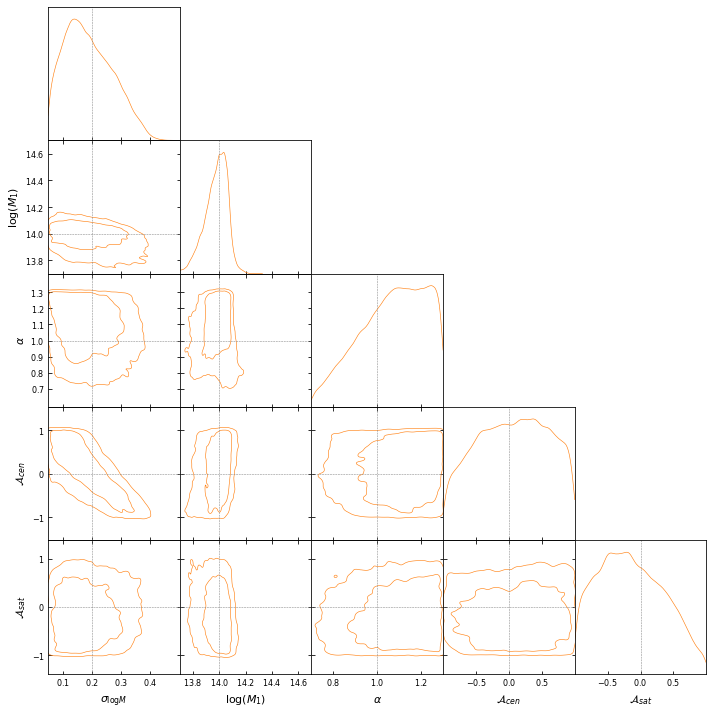

In [156]:
g = plots.get_subplot_plotter()
g.triangle_plot(all_samples, filled=False, params=summary_pnames,
               markers=summary_truths, 
                contour_colors = colors,
               param_limits = dict(zip(summary_pnames, summary_bounds)))
g.fig.savefig('%s_%s_HOD.pdf'%(mock_name, model_name), format = 'pdf', bbox_inches='tight')

In [157]:
summary_idxs=[1,4,7,8,14]
#summary_idxs=#range(9)#[7,8,14,15]

summary_pnames = [plot_param_names[i] for i in summary_idxs]
summary_truths = [true_vals[i] for i in summary_idxs]
summary_bounds = [plot_param_bounds[i] for i in summary_idxs]

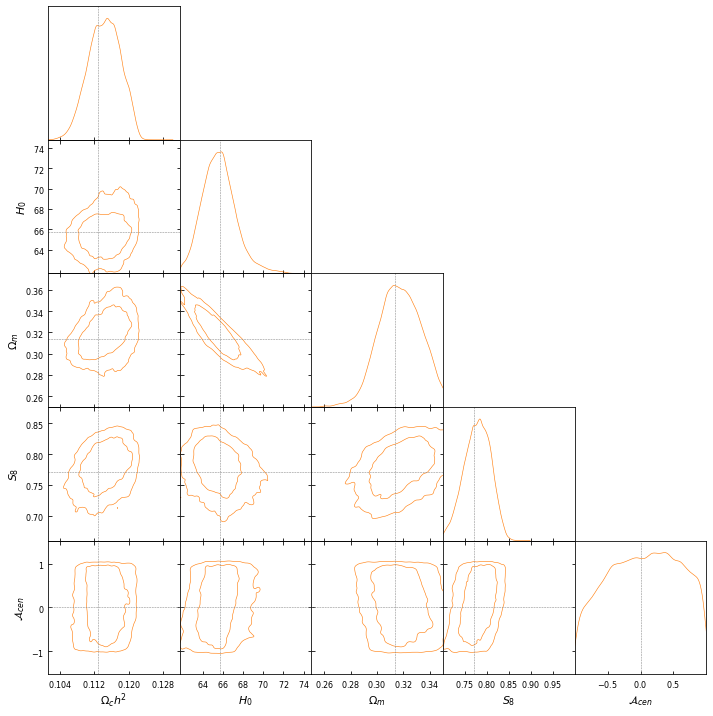

In [158]:
g = plots.get_subplot_plotter()
g.triangle_plot(all_samples, filled=False, params=summary_pnames,
               markers=summary_truths, 
                contour_colors = colors,
               param_limits = dict(zip(summary_pnames, summary_bounds)))
g.fig.set_facecolor('w')

g.fig.savefig('%s_%s_AB.pdf'%(mock_name, model_name), format = 'pdf', bbox_inches='tight')

In [159]:
for chain in c.chains:
    print chain.name
    print len(np.unique(chain.chain[:,6]))/(1.0*chain.chain.shape[0])

NameError: name 'c' is not defined

In [ ]:
param_names

In [ ]:
for pname in summary_pnames:
    print pname,'\t',
print
print '*'*20

for MAP in MAPs:
    for pname in summary_pnames:
        print MAP[pname],'\t',
    print 
print '*'*20
for st in summary_truths:
    print '%.4f'%st,'\t'*2,

In [ ]:
MAP = [MAPs[0][pname] for pname in summary_pnames]

In [ ]:
summary_names = ['Om','S8','H0']
Om = 0.3089
S8 = 0.8228*np.sqrt(0.3089/0.3)
h = 0.6777
H0=h*100
true_vals_dict = dict(zip(summary_names, [Om, S8, H0]))

true_point = np.array([true_vals_dict[name] for name in summary_names])

In [ ]:
from numpy.random import multivariate_normal

In [ ]:
_pnames, corr = c.analysis.get_correlations()

In [ ]:
print _pnames

In [ ]:
corr = corr[np.array([9,12])]

In [ ]:
im = plt.imshow(corr[:,:8], vmin = -1, vmax = 1)
plt.colorbar(im)

In [ ]:
#idxs = np.ones_like(corr[0], dtype=bool)
#idxs[9] = idxs[12] = False
_corr = corr[:, :8]
plt.hist(_corr.flatten(), bins = np.linspace(-1, 1, 21), normed=True)

In [ ]:
from scipy.linalg import inv

for i,chain in enumerate(c.chains[:4]):
    print chain.name
    
    names, cov = c.analysis.get_covariance(chain.name)
    #print cov
    idxs = np.array([names.index(sp) for sp in summary_pnames])
    cov = cov[idxs][:,idxs]
    inv_cov = inv(cov)

    #max_dict = c.analysis.get_max_posteriors()[i]#chain.name)
    #max_point = np.array([max_dict[name] for name in summary_pnames])
    max_dict = c.analysis.get_summary(chains = chain.name)
    max_point = np.array([max_dict[name][1] for name in summary_pnames])
    print true_point
    print max_point
    print np.sqrt(np.diag(cov))
    delta = true_point-max_point
    d2 = delta.T.dot(inv_cov.dot(delta))
    print np.sqrt(d2)
    true_d = np.sqrt(d2)
    
    all_points = c.chains[i].chain[:,idxs]
    all_delta = (all_points-max_point)#[:1000]
    all_d2 = np.array([d.T.dot(inv_cov.dot(d)) for d in all_delta])
    all_d = np.sqrt(all_d2)
    print 'Sorta p value:', np.sum(true_d<all_d)*1.0/all_d.shape[0]

    posterior_samples = multivariate_normal(max_point, cov, 25000)
    name = '%d Fit'%i
    c.add_chain(posterior_samples, parameters=summary_pnames, name = name)
    
    fig = c.plotter.plot(chains = [0+i,4+i], figsize='PAGE', parameters =summary_pnames\
                                    , truth=summary_truths, extents=summary_bounds)
    plt.show()


In [ ]:
c.chains[0].chain.shape

In [ ]:
def lnlike(theta, param_names, fixed_params, r_bin_centers, y, combined_inv_cov):

    param_dict = dict(izip(param_names, theta))
    param_dict.update(fixed_params)

    emu_preds = []
    for _emu, rbc in izip(_emus, r_bin_centers):
        y_bar = _emu.emulate_wrt_r(param_dict, rbc)[0]

        emu_preds.append(10**y_bar)
        #delta = y_bar - y
        #chi2 -= np.dot(delta, np.dot(combined_inv_cov, delta))

    emu_pred = np.hstack(emu_preds)

    delta = emu_pred - y
    #print delta
    return - np.dot(delta, np.dot(combined_inv_cov, delta))


In [ ]:
c.chains[0].name.split()

In [ ]:
deltas = []
rmins = []
for chain in c.chains:
    summary = c.analysis.get_parameter_summary(chain, r'$S_8$')
    delta = summary[2]-summary[0]
    deltas.append(delta)
    rmin = chain.name.split()[-1][:-1]
    rmins.append(float(rmin))
    print rmin, delta

In [ ]:
true_s8 = 0.8349

In [ ]:
plt.plot(np.array(rmins), np.array(deltas)/true_s8, color = 'b')
plt.xscale('log')
plt.ylabel(r'$\Delta S_8/S_8$')
plt.xlabel(r'$r_{min}$ [Mpc/h]')